In [1]:
# read dataset one image

# image_size=128, batch_size:256, epochs=10, drop_out=0.25,0.5, score=2.6896452718267965e-05
# image_size=128, batch_size:128, epochs=10, drop_out=0.25,0.5, score=2.0310855384028685e-05
# image_size=128, batch_size:128, epochs=20, drop_out=0.25,0.5, score=1.1700560265438025e-06
# image_size=128, batch_size:128, epochs=20, drop_out=0.1,0.2, score=0.002593253495028333

from keras.preprocessing import image

imageSize = 128
batch_size = 128
is_debug = False

def readImage(path):
    img = image.load_img(path, target_size=(imageSize, imageSize))
    x = image.img_to_array(img)
    x = x.astype('float32')
    x /= 255.0
    return x

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def getLabel(path):
    name = path[path.rfind('/') + 1:path.index('.')]
#     print (name)
    return 1 if name == 'dog' else 0
print ("getLabel done")

getLabel done


In [3]:
import helper

def readFeatureAndLabel():
    train_files = helper.get_train_files()
    file_count = 1024 if is_debug else len(train_files)
    print("readFeatureAndLabel file_count=" + str(file_count))
    train_feature = []
    train_label = []
    for i in range(file_count):
        f = train_files[i]
#         print (f)
        train_feature.append(readImage(f))
        train_label.append(getLabel(f))
    
    return train_feature, train_label

In [4]:
import numpy as np

total_feature, total_label = readFeatureAndLabel()
total_feature = np.array(total_feature)
# total_feature = total_feature.astype('float32')
# total_feature /= 255

total_label = np.array(total_label)
# print (total_label)

readFeatureAndLabel file_count=25000


In [5]:
# split train_feature, train_label, validation_feature, validation_label
from sklearn.model_selection import train_test_split
train_feature, validation_feature, train_label, validation_label = train_test_split(total_feature, total_label, test_size=0.1, random_state=1)
    
# print (train_label)
print("done")

done


In [6]:
print(type(train_feature))

<class 'numpy.ndarray'>


In [6]:
import math

def score_fun(label_pre):
    total_score = 0
    size = validation_label.size
    for i in range(size):
        y = validation_label[i]
        yp = label_pre[i]
#         print (str(y) + " " + str(yp))
        try:
            total_score = y * math.log(yp) + (1 - y)*math.log(1-yp)
        except:
            print (str(i) + ": " + str(y) + " - " + str(yp))
    return -total_score/size
print("done")

done


In [17]:
# convolutional
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
# import keras.regularizer.Regularizer as regularizers
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(imageSize, imageSize, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_feature, train_label, batch_size=batch_size, epochs=20, validation_data=(validation_feature, validation_label))

pre_val_label = model.predict(x=validation_feature, batch_size=batch_size)
# for i in range(pre_val_label.size):
#     print(str(i) + ": " + str(pre_val_label[i]))
score = model.evaluate(validation_feature, validation_label, batch_size=batch_size)
print (score)


ModuleNotFoundError: No module named 'keras.regularizer'

In [29]:
# This is Plan B

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers

model = Sequential()

model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(imageSize, imageSize, 3)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(16, (3, 3), activation='relu')) #64
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.14))

model.add(Conv2D(32, (3, 3), activation='relu')) #32
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(64, (3, 3), activation='relu')) #16
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.15))

# model.add(Conv2D(128, (3, 3), activation='relu')) #8
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Dense(1, activation='sigmoid'))

opt = optimizers.SGD(lr=0.07, momentum=0.8)
model.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=['accuracy'])
# optimizer='rmsprop'

history = model.fit(train_feature, train_label, batch_size=batch_size, epochs=60, validation_data=(validation_feature, validation_label))

pre_val_label = model.predict(x=validation_feature, batch_size=batch_size)
# for i in range(pre_val_label.size):
#     print(str(i) + ": " + str(pre_val_label[i]))
score = model.evaluate(validation_feature, validation_label, batch_size=batch_size)
print (score)

Train on 22500 samples, validate on 2500 samples
Epoch 1/60
22500/22500 [==============================] - 12s 519us/step - loss: 0.6914 - acc: 0.5224 - val_loss: 0.6916 - val_acc: 0.5152
Epoch 2/60
22500/22500 [==============================] - 10s 447us/step - loss: 0.6911 - acc: 0.5219 - val_loss: 0.6922 - val_acc: 0.5372
Epoch 3/60
22500/22500 [==============================] - 10s 447us/step - loss: 0.6878 - acc: 0.5371 - val_loss: 0.6810 - val_acc: 0.5412
Epoch 4/60
22500/22500 [==============================] - 10s 448us/step - loss: 0.6764 - acc: 0.5728 - val_loss: 0.6736 - val_acc: 0.5896
Epoch 5/60
22500/22500 [==============================] - 10s 447us/step - loss: 0.6463 - acc: 0.6291 - val_loss: 0.6460 - val_acc: 0.6416
Epoch 6/60
22500/22500 [==============================] - 10s 447us/step - loss: 0.6135 - acc: 0.6684 - val_loss: 0.6333 - val_acc: 0.6500
Epoch 7/60
22500/22500 [==============================] - 10s 445us/step - loss: 0.5768 - acc: 0.7019 - val_loss: 0.6

22500/22500 [==============================] - 10s 443us/step - loss: 0.1004 - acc: 0.9612 - val_loss: 0.3812 - val_acc: 0.8868
Epoch 60/60
2500/2500 [==============================] - 1s 234us/step
[0.4582778548240662, 0.8787999998092652]


In [30]:
# score the model

score = score_fun(pre_val_label)

print (score)

20: 1 - [1.]
34: 1 - [1.]
38: 1 - [1.]
39: 1 - [1.]
45: 1 - [1.]
46: 1 - [1.]
50: 1 - [1.]
70: 1 - [1.]
91: 1 - [1.]
97: 1 - [1.]
101: 1 - [1.]
107: 1 - [1.]
108: 1 - [1.]
121: 1 - [1.]
174: 1 - [1.]
180: 1 - [1.]
188: 1 - [1.]
206: 0 - [0.]
207: 1 - [1.]
219: 1 - [1.]
238: 1 - [1.]
239: 1 - [1.]
257: 1 - [1.]
265: 1 - [1.]
269: 1 - [1.]
275: 1 - [1.]
277: 1 - [1.]
291: 1 - [1.]
318: 1 - [1.]
325: 1 - [1.]
333: 1 - [1.]
336: 1 - [1.]
348: 1 - [1.]
353: 1 - [1.]
360: 1 - [1.]
362: 1 - [1.]
366: 1 - [1.]
382: 1 - [1.]
397: 1 - [1.]
423: 1 - [1.]
440: 1 - [1.]
457: 1 - [1.]
464: 1 - [1.]
468: 1 - [1.]
486: 1 - [1.]
489: 1 - [1.]
517: 1 - [1.]
544: 1 - [1.]
568: 1 - [1.]
576: 1 - [1.]
579: 1 - [1.]
594: 1 - [1.]
596: 1 - [1.]
600: 1 - [1.]
620: 1 - [1.]
668: 1 - [1.]
669: 1 - [1.]
677: 1 - [1.]
687: 1 - [1.]
698: 1 - [1.]
699: 1 - [1.]
702: 1 - [1.]
711: 1 - [1.]
714: 1 - [1.]
722: 1 - [1.]
733: 1 - [1.]
736: 1 - [1.]
739: 1 - [1.]
750: 1 - [1.]
751: 1 - [1.]
771: 1 - [1.]
830: 1 - [1.]
84

In [31]:
# save weights
model.save_weights('weights.h5')

In [32]:
import helper

test_files = helper.get_test_files()
test_files = sorted(test_files, key=lambda s: (len(s), s))

test_file_size = 128 if is_debug else len(test_files)

test_feature = []
for i in range(test_file_size):
    test_feature.append(readImage(test_files[i]))
test_feature = np.asarray(test_feature)
print(type(test_feature))
test_label = model.predict(test_feature, batch_size=batch_size)
print (len(test_label))

<class 'numpy.ndarray'>
12500


In [33]:
test_label_output = []
for i in range(len(test_label)):
    test_label_output.append([i + 1, test_label[i]])
    
print (len(test_label_output))
test_label_output = np.array(test_label_output)
np.savetxt("submission.csv", test_label_output, fmt='%d,%f', delimiter=',', header="id,label", comments="")
print('done')

12500
done


Text(0.5,1,'Accuracy Curves')

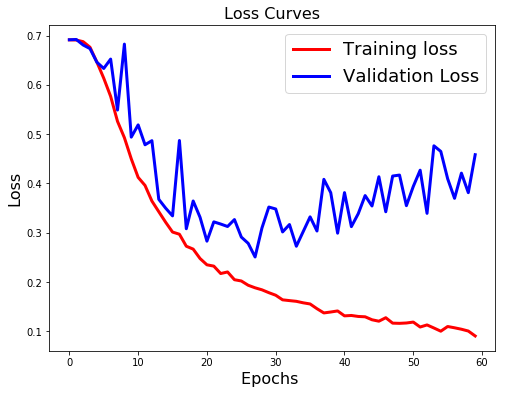

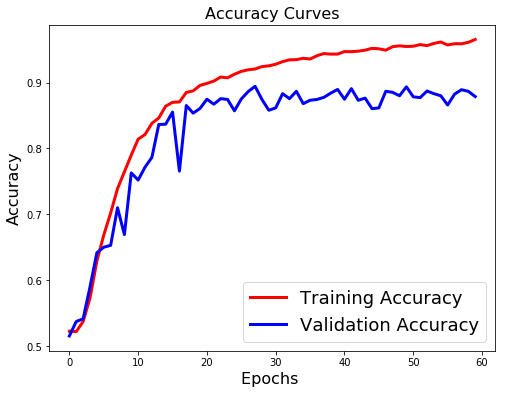

In [34]:
import matplotlib.pyplot as plt

print (history)
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [14]:
# import numpy as np

# csv_array= np.array([(1, 1.2),(2, 2.3),(3, 3.4)])
# np.savetxt("array.csv", csv_array, fmt='%d,%f',delimiter=',', header="id,label", comments="")